Полное описание

https://docs.google.com/document/d/1u-JiK2opyDeZ2h21nnnmuumyRyYlUL5K3Id7QTWihOU/edit#

In [1]:
from collections import defaultdict
from typing import Dict, List, Optional, Tuple
import random

import gym

from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

/Users/mikhailgashkov/.venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# Часть первая, с блекджеком и стратегиями

1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

In [2]:
DEFAULT_GAME_NAME = 'Blackjack-v0'

class GameStates:
    def __init__(self):
        self.states = []
        self.rewards = []
        self.actions = []
    
    def __repr__(self) -> Dict[str, List]:
        return {
            'states': self.states, 
            'rewards': self.rewards,
            'actions': self.actions
        }

    def add_states(self, state, reward, action):
        self.states.append(state)
        self.rewards.append(reward)
        self.actions.append(action)


class GameBlackjack:
    def __init__(
        self,
        game_name: str = DEFAULT_GAME_NAME,
        epsilon: float = 0.9,
    ):
        try:
            self.env = gym.make(game_name)
        except KeyError as exc:
            print(f'Please, select existing game in gym. Error message is {exc}')
        self.game_states = GameStates()
        self.epsilon = epsilon
        
    def __repr__(self):
        return self.game_states.__repr__()
    
    def play_game(
        self, 
        strategy: callable, 
        silent: str = False,
        Q: Optional[Dict[int, Dict[int, float]]] = None, 
    ):
        self.env.reset() # start new game
        action = None
        while True:
            state = self.env._get_obs()
            action = strategy(
                env=self.env, 
                state=state, 
                action=action,
                epsilon=self.epsilon,
                Q=Q,
            )
            next_state, reward, finished, _ = self.env.step(action)
  
            self.game_states.add_states(state, reward, action)
            if finished:
                break
        self.env.close()
        if not silent:
            if reward > 0:
                print('You win!')
            elif reward < 0:
                print('Your lose!')
            else:
                print('Draw')
        
        return self.__repr__()

In [3]:
def random_strategy(env: gym.Env, *args, **kwargs) -> int:
    return env.action_space.sample()

# Let us try simple random strategy

game = GameBlackjack()

game.play_game(strategy=random_strategy)

You win!


{'states': [(19, 2, False)], 'rewards': [1.0], 'actions': [0]}

In [4]:
def strategy_first(
    env: gym.Env, 
    state: int, 
    *args, **kwargs,
) -> int:
    """
    Strategy from task 1:
    Stand (0) in >=19 and <= 21,
    Hit (1) else.
    """
    if state in [19, 20, 21]:
        return 0
    else:
        return 1
    
    
game = GameBlackjack()

print(game.play_game(strategy=strategy_first))

Your lose!
{'states': [(17, 5, True), (18, 5, True), (19, 5, True), (21, 5, True), (14, 5, False), (17, 5, False)], 'rewards': [0, 0, 0, 0, 0, -1], 'actions': [1, 1, 1, 1, 1, 1]}


In [5]:
# Monte Carlo first visit

def monte_carlo_estimation(
    strategy: callable,
    game_name: str = DEFAULT_GAME_NAME, 
    gamma: float = 0.95,
    num_episodes : int = 10_000,
) -> Tuple[Dict[tuple, float], Dict[tuple, List[int]]]:
    Ret = defaultdict(list)
    V = defaultdict(int)
    
    for ep in tqdm(range(num_episodes)):
        game = GameBlackjack(game_name)
        game_result = game.play_game(
            strategy=strategy, 
            silent=True
        )
        num_moves = len(game_result['rewards'])
        G = 0
        for move in range(num_moves - 1, -1, -1):
            G = gamma * G + game_result['rewards'][move]
            S = game_result['states'][move]
            if S not in game_result['states'][:move]:
                Ret[S].append(G)
                V[S] = np.mean(Ret[S])
    return V, Ret

In [7]:
values,r = monte_carlo_estimation(num_episodes=100_000, strategy=strategy_first)

100%|██████████| 100000/100000 [04:46<00:00, 349.26it/s]


In [8]:
{i: values[i] for i in random.choices(list(values.keys()), k=20)}

{(12, 7, True): -0.868962361111111,
 (9, 9, False): -0.9221945189274449,
 (21, 5, True): -0.93267595193418,
 (17, 4, True): -0.9091417151162791,
 (19, 1, True): -0.9179334971910111,
 (16, 5, False): -0.9765313937442501,
 (19, 8, False): -0.9909409667194929,
 (15, 7, True): -0.8996809965551181,
 (18, 8, True): -0.9199541039156628,
 (15, 2, False): -0.9705264077102804,
 (19, 7, False): -0.9936125319693097,
 (12, 4, False): -0.9542560312499998,
 (5, 8, False): -0.89408362435567,
 (20, 9, False): -0.9966163141993958,
 (21, 5, False): -1.0,
 (6, 10, False): -0.9037820098499061,
 (21, 6, True): -0.9345884536082472,
 (19, 4, False): -0.9919869638351555}

Я вывел только 20 штук, но посмотрел на весь массив чисел и видно, что казино всегда выигрывает (а игрок проигрывает): все средние около -1. 

In [9]:
def find_max_state(Q: Dict[int, float]) -> float:
    cur_r = 0.0
    best_action = 0
    for action, r in Q.items():
        if r >= cur_r:
            cur_r = r
            best_action = action
    return best_action
    
    
def eps_greedy_strategy(
    env: gym.Env, 
    Q: Dict[int, Dict[int, float]],
    state: Optional[int] = None,
    epsilon: float = 0.8,
    *args, **kwargs,
) -> int:
    """
    Eps greedy strategy
    """
    if state is None:
        state = env._get_obs()
    if random.random() > epsilon:
        return find_max_state(Q[state])
    else:
        return random.randint(0, env.action_space.n - 1)

In [101]:
# Monte Carlo control

def monte_carlo_control_estimation(
    strategy: callable,
    game_name: str = DEFAULT_GAME_NAME, 
    gamma: float = 0.95,
    num_episodes : int = 10_000,
    epsilon: float = 0.9,
) -> Tuple[int, Dict[tuple, float], Dict[tuple, List[int]], GameBlackjack]:
    Q = defaultdict(lambda: defaultdict(float))
    Ret = defaultdict(lambda: defaultdict(list))
    # First index - state, second - action
    ans = []
    for ep in tqdm(range(num_episodes)):
        game = GameBlackjack(game_name, epsilon)
        game_result = game.play_game(
            strategy=strategy, 
            silent=True,
            Q=Q,
        )
        num_moves = len(game_result['rewards'])
        G = 0
        S_A = list(zip(game_result['states'], game_result['actions']))
        for move in range(num_moves - 1, -1, -1):
            G = gamma * G + game_result['rewards'][move]
            A = game_result['actions'][move]
            S = game_result['states'][move]
            if (S, A) not in S_A[:move]:
                Ret[S][A].append(G)
                Q[S][A] = np.mean(Ret[S][A])
        if (ep + 1) % 10_000 == 0:
            def best_policy(env, Q, state, *args, **kwargs): 
                return eps_greedy_strategy(env, Q, state, epsilon=epsilon)
            ans.append((ep, Q, best_policy, game))
    return ans

In [102]:
_, Q_for_best_policy, best_policy, game = monte_carlo_control_estimation(
    num_episodes=100_000, strategy=eps_greedy_strategy,
    epsilon=0.5
)[-1]

100%|██████████| 100000/100000 [04:34<00:00, 363.73it/s]


In [105]:
average_reward_best_strategy(best_policy, Q_for_best_policy, game)

-0.26019

In [103]:
best_policy(env=game.env, Q=Q_for_best_policy, state=0)

0

In [104]:
def average_reward_best_strategy(
    strategy: callable,
    Q: Dict[tuple, float],
    game: GameBlackjack,
    n_episodes: int = 100_000,
):
    total_rewards = 0
    for episone in range(n_episodes):
        res = game.play_game(strategy=strategy, silent=True, Q=Q)
        total_rewards += res['rewards'][-1]
    return total_rewards / n_episodes

In [130]:
#  Посмотрим, насколько хорошо выучивается алгоритм за разное количество игр

gammas = list(np.arange(0., 1.2, 0.2))
episodes = list(range(10_000, 120_000, 10_000))
best_rewards = defaultdict(lambda: defaultdict(list))

for gamma in gammas:
    best_policies = monte_carlo_control_estimation(
        num_episodes=episodes[-1], strategy=eps_greedy_strategy,
        epsilon=0.5, gamma=gamma,
    )
    for i, n_episodes in enumerate(episodes):
        best_rewards[gamma]['n_episodes'].append(best_policies[i][0])
        best_rewards[gamma]['reward'].append(
            average_reward_best_strategy(
                Q=best_policies[i][1],
                strategy=best_policies[i][2],
                game=best_policies[i][3])
        )

100%|██████████| 110000/110000 [04:07<00:00, 444.20it/s]


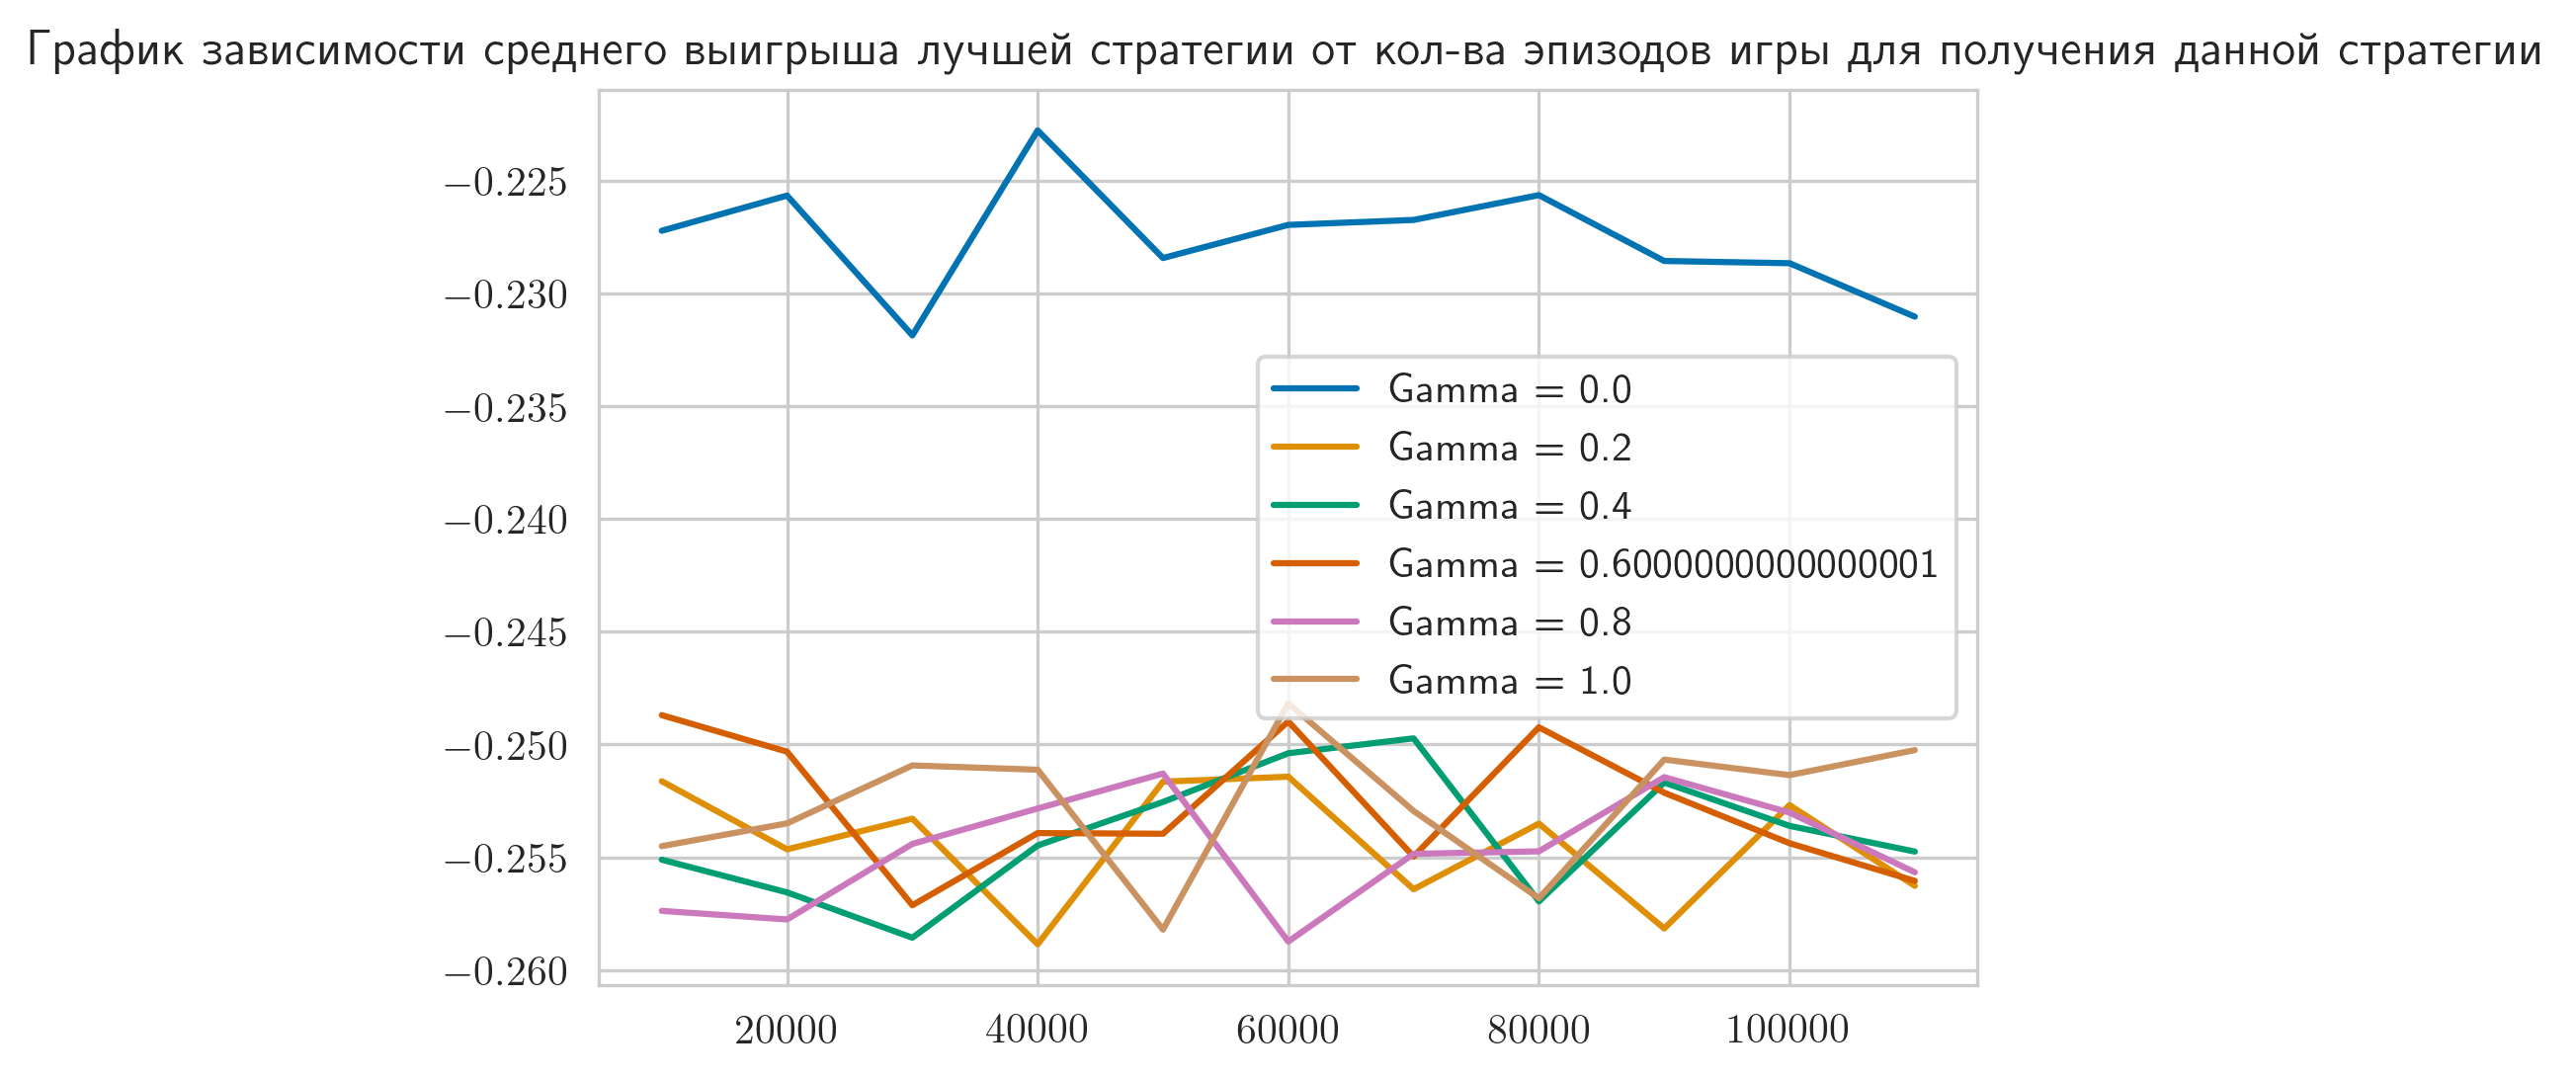

In [131]:
plt.title('График зависимости среднего выигрыша лучшей стратегии от кол-ва эпизодов игры для получения данной стратегии')
for gamma in gammas:
    plt.plot(best_rewards[gamma]['n_episodes'], best_rewards[gamma]['reward'], label=f'Gamma = {gamma}')
# plt.xlabel('n_episodes')
# plt.ylabel('reward')
plt.legend()
plt.show()

# Часть вторая, удвоенная

4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [132]:
# https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py

import gym
from gym import spaces
from gym.utils import seeding


def cmp(a, b):
    return float(a > b) - float(a < b)


# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnvDouble(gym.Env):

    def __init__(self, natural=False, sab=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))
        )
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  
            # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.0
            else:
                done = False
                reward = 0.0
        elif action == 0:  
            # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5
        elif action == 2:
            #double game
            done = True 
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                reward = -2.
            else:
                ...
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(draw_card(self.np_random))
                reward = cmp(
                    score(self.player), score(self.dealer)
                ) * 2
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

In [177]:
# Registration of new env

from gym.envs.registration import register, registry

DOUBLE_GAME_NAME = 'Blackjack-v1'

gym.envs.toy_text.blackjack.BlackjackEnvDouble = BlackjackEnvDouble
    
if DOUBLE_GAME_NAME in registry.env_specs:
    del registry.env_specs[DOUBLE_GAME_NAME]
    
register(
    id=DOUBLE_GAME_NAME,
    entry_point='gym.envs.toy_text.blackjack:BlackjackEnvDouble',
)

In [178]:
# Check if it is Ok

enva = gym.make(DOUBLE_GAME_NAME)
enva.reset()
enva.step(2)

((16, 9, False), 2.0, True, {})

In [137]:
_, Q_for_best_policy, best_policy, game = monte_carlo_control_estimation(
    num_episodes=10_000, strategy=eps_greedy_strategy,
    game_name=DOUBLE_GAME_NAME,
    epsilon=0.9
)[-1]

100%|██████████| 10000/10000 [00:20<00:00, 482.60it/s]


In [138]:
best_policy(env=game.env, Q=Q_for_best_policy, state=0)

2

In [139]:
average_reward_best_strategy(best_policy, Q_for_best_policy, game)

-0.51558

In [ ]:
#  Посмотрим, насколько хорошо выучивается алгоритм за разное количество игр

gammas = list(np.arange(0., 1.2, 0.2))
episodes = list(range(10_000, 120_000, 10_000))
best_rewards = defaultdict(lambda: defaultdict(list))

for gamma in gammas:
    best_policies = monte_carlo_control_estimation(
        num_episodes=episodes[-1], strategy=eps_greedy_strategy,
        epsilon=0.5, gamma=gamma,
        game_name=DOUBLE_GAME_NAME,
    )
    for i, n_episodes in enumerate(episodes):
        best_rewards[gamma]['n_episodes'].append(best_policies[i][0])
        best_rewards[gamma]['reward'].append(
            average_reward_best_strategy(
                Q=best_policies[i][1],
                strategy=best_policies[i][2],
                game=best_policies[i][3])
        )

 10%|█         | 11522/110000 [00:29<03:53, 421.71it/s]

In [ ]:
plt.title('График зависимости среднего выигрыша лучшей стратегии от кол-ва эпизодов игры для получения данной стратегии')
for gamma in gammas:
    plt.plot(best_rewards[gamma]['n_episodes'], best_rewards[gamma]['reward'], label=f'Gamma = {gamma}')
plt.xlabel('n_episodes')
plt.ylabel('reward')
plt.legend()
plt.show()

# Часть третья, в главной роли — Дастин Хоффма

6. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).

7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [167]:
# https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py

MIN_NUM_OF_CARDS = 15

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
INITIAL_DECK = [*list(range(1, 11)), *[10] * 3] * 4

import gym
from gym import spaces
from gym.utils import seeding


def cmp(a, b):
    return float(a > b) - float(a < b)

deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnvDoubleInfinite(gym.Env):

    def __init__(self, natural=False, sab=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))
        )
        self.seed()
        
        self.deck = INITIAL_DECK.copy()
        
        # Реализуем Половинки со страницу Википедии
        self.card_points = {
            1: -1, 
            2: 0.5,
            3: 1,
            4: 1,
            5: 1.5,
            6: 1,
            7: 0.5,
            8: 0,
            9: -0.5,
            10: -1,
        }
        self.point_counter = 0

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab
    
    def draw_card(self, np_random):
        random_card_position = random.randint(0, len(self.deck) - 1)
        random_card = self.deck.pop(random_card_position)
        self.point_counter += self.card_points[random_card]
        return int(random_card)
    
    def draw_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_card(np_random)]

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  
            # hit: add a card to players hand and return
            self.player.append(self.draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.0
            else:
                done = False
                reward = 0.0
        elif action == 0:  
            # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5
        elif action == 2:
            #double game
            done = True 
            self.player.append(self.draw_card(self.np_random))
            if is_bust(self.player):
                reward = -2.
            else:
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(self.draw_card(self.np_random))
                reward = cmp(
                    score(self.player), score(self.dealer)
                ) * 2
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), self.point_counter)

    def reset(self):
        if len(self.deck) < MIN_NUM_OF_CARDS:
            self.deck = INITIAL_DECK.copy()
            self.point_counter = 0
        self.dealer = self.draw_hand(self.np_random)
        self.player = self.draw_hand(self.np_random)
        return self._get_obs()

In [168]:
# Registration of new env

from gym.envs.registration import register, registry

INFINITE_GAME_NAME = 'Blackjack-v10'

gym.envs.toy_text.blackjack.BlackjackEnvDoubleInfinite = BlackjackEnvDoubleInfinite
    
if DOUBLE_GAME_NAME in registry.env_specs:
    del registry.env_specs[DOUBLE_GAME_NAME]
    
register(
    id=INFINITE_GAME_NAME,
    entry_point='gym.envs.toy_text.blackjack:BlackjackEnvDoubleInfinite',
)

In [169]:
enva = gym.make(INFINITE_GAME_NAME)
enva.reset()
enva.step(2)

((17, 10, False, 2.0), 0.0, True, {})

In [170]:
_, Q_for_best_policy, best_policy, game = monte_carlo_control_estimation(
    num_episodes=10_000, strategy=eps_greedy_strategy,
    game_name=INFINITE_GAME_NAME,
    epsilon=0.9
)[-1]

100%|██████████| 10000/10000 [00:20<00:00, 492.39it/s]


In [171]:
best_policy(env=game.env, Q=Q_for_best_policy, state=0)

2

In [172]:
average_reward_best_strategy(best_policy, Q_for_best_policy, game)

-0.50831

In [ ]:
#  Посмотрим, насколько хорошо выучивается алгоритм за разное количество игр

gammas = list(np.arange(0., 1.2, 0.2))
episodes = list(range(10_000, 120_000, 10_000))
best_rewards = defaultdict(lambda: defaultdict(list))

for gamma in gammas:
    best_policies = monte_carlo_control_estimation(
        num_episodes=episodes[-1], strategy=eps_greedy_strategy,
        epsilon=0.5, gamma=gamma,
        game_name=INFINITE_GAME_NAME,
    )
    for i, n_episodes in enumerate(episodes):
        best_rewards[gamma]['n_episodes'].append(best_policies[i][0])
        best_rewards[gamma]['reward'].append(
            average_reward_best_strategy(
                Q=best_policies[i][1],
                strategy=best_policies[i][2],
                game=best_policies[i][3])
        )

In [ ]:
plt.title('График зависимости среднего выигрыша лучшей стратегии от кол-ва эпизодов игры для получения данной стратегии')
for gamma in gammas:
    plt.plot(best_rewards[gamma]['n_episodes'], best_rewards[gamma]['reward'], label=f'Gamma = {gamma}')
plt.xlabel('n_episodes')
plt.ylabel('reward')
plt.legend()
plt.show()

# Часть четвёртая, опциональная

8. Реализуйте поиск стратегии в блекджеке с известной моделью из первой части, решив уравнения Беллмана для V* или Q*. Для этого вам придётся сначала оценить параметры модели, т.е. найти или обучить вероятности переходов между состояниями.

9. Реализуйте вариант из второй или третьей части, в котором есть ещё возможность делать split: в случае, когда игроку пришли две одинаковые карты, он может разбить руку на две, внести ещё одну ставку и продолжать играть две руки сразу (как будто за двоих игроков). Скорее всего, обыграть казино получится только в варианте с разрешённым split’ом и подсчётом карт; если получится, это будет отличное завершение проекта!